## Kaggle Challenge - Diagnosis of Lymphocytosis

This is the code for reproducing our submissions. This code is inspired from the github https://github.com/utayao/Atten_Deep_MIL/tree/master/utl.

In [1]:
from google.colab import drive,files 

drive.mount('/content/drive',force_remount=True) 

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2MB 30kB/s 
     |████████████████████████████████| 460kB 50.1MB/s 
     |████████████████████████████████| 3.0MB 53.5MB/s 
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorflow-2.4.1:
      Successfully uninstalled tensorflow-2.4.1


In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('/content/drive/MyDrive/3md3070-dlmi/clinical_annotation.csv')

In [5]:
neg_ = 0
pos_ =  0

for i in range(len(df['LABEL'])):
  if df['LABEL'][i]==0:
    neg_+=1
  if df['LABEL'][i]==1:
    pos_+=1
print('There is', (pos_/163)*100, '% of sick people.')
print('There is', (neg_/163)*100, '% of healthy people.')

There is 69.32515337423312 % of sick people.
There is 30.67484662576687 % of healthy people.


In [6]:
!git clone https://github.com/danielAmar02/DL_MI.git 

Cloning into 'DL_MI'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 22 (delta 4), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (22/22), done.


## Model & Training

In [3]:
import numpy as np
import torch
import torch.utils.data as data_utils  
from torchvision import datasets, transforms 
import glob
import imageio 

In [4]:
import numpy as np
import time
from random import shuffle
import argparse
from keras.models import Model
import glob
import scipy.misc as sci
import tensorflow as tf

from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
import matplotlib.pyplot as plt

import os
from os import path
from tqdm import tqdm

In [5]:
def test_eval(model, test_set):
    """Evaluate on testing set.
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training mi-Cell-Net model.
    test_set : list
        A list of testing set contains all training bags features and labels.
    Returns 
    -----------------
    test_loss : float
        Mean loss of evaluating on testing set.
    test_acc : float
        Mean accuracy of evaluating on testing set.
    """
    num_test_batch = len(test_set)
    test_loss = np.zeros((num_test_batch, 1), dtype=float)
    test_acc = np.zeros((num_test_batch, 1), dtype=float)
    for ibatch, batch in enumerate(test_set):
        result = model.test_on_batch(x=batch[0], y=batch[1])
        test_loss[ibatch] = result[0]
        test_acc[ibatch] = result[1]
    return np.mean(test_loss), np.mean(test_acc)

In [6]:
%cd /content/DL_MI

from functions import Get_train_valid_Path

def train_eval(model, train_set, irun, ifold):

    """Evaluate on training set. Use Keras fit_generator
    Parameters
    -----------------
    model : keras.engine.training.Model object
        The training mi-Cell-Net model.
    train_set : list
        A list of training set contains all training bags features and labels.
    Returns
    -----------------
    model_name: saved lowest val_loss model's name
    """
    batch_size = 1
    model_train_set, model_val_set = Get_train_valid_Path(train_set, train_percentage=0.8)

    train_gen = DataGenerator(batch_size=1, shuffle=False).generate(model_train_set)
    val_gen = DataGenerator(batch_size=1, shuffle=False).generate(model_val_set)

    if not path.exists('/content/Saved_model'):
      Save_model = '/content/Saved_model'
      os.mkdir(Save_model)

    model_name = '/content/Saved_model' + "_Batch_size_" + str(batch_size) + "epoch_" + "best.hd5"

    checkpoint_fixed_name = ModelCheckpoint(model_name,
                                            monitor='val_loss', verbose=1, save_best_only=True,
                                            save_weights_only=True, mode='auto', period=1)

    EarlyStop = EarlyStopping(monitor='val_loss', patience=10)

    callbacks = [checkpoint_fixed_name, EarlyStop]

    #weight = {0:70,1:30}
    
    if tf.test.is_gpu_available():
      with tf.device("/device:GPU:0"):
        history = model.fit_generator(train_gen, steps_per_epoch=len(model_train_set)//batch_size,
                                             epochs=40, validation_data=val_gen,
                                            validation_steps=len(model_val_set)//batch_size, callbacks=callbacks)
    else:
      history = model.fit_generator(train_gen, steps_per_epoch=len(model_train_set)//batch_size,
                                             epochs=40, validation_data=val_gen,
                                            validation_steps=len(model_val_set)//batch_size, callbacks=callbacks)

    model.save('/content/Saved_model/saved')


    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    train_prec = history.history['precision_m']
    val_prec = history.history['val_precision_m']

    train_BA = history.history['BA']
    val_BA = history.history['val_BA']


    fig = plt.figure()
    plt.plot(train_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    save_fig_name = '/content/Saved_model/' + str(irun) + '_' + str(ifold) + "_loss_batchsize_" + str(batch_size) + "_epoch"  + ".png"
    fig.savefig(save_fig_name)

    fig = plt.figure()
    plt.plot(train_prec)
    plt.plot(val_prec)
    plt.title('precision')
    plt.ylabel('precision')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    save_fig_name = '/content/Saved_model/' + str(irun) + '_' + str(ifold) + "_precision_" + str(batch_size) + "_epoch"  + ".png"
    fig.savefig(save_fig_name)

    fig = plt.figure()
    plt.plot(train_BA)
    plt.plot(val_BA)
    plt.title('balanced accuracy')
    plt.ylabel('balanced accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    save_fig_name = '/content/Saved_model/' + str(irun) + '_' + str(ifold) + "_BA_" + str(batch_size) + "_epoch"  + ".png"
    fig.savefig(save_fig_name)

    return model_name


/content/DL_MI


In [7]:
import sys
import time
from random import shuffle
import numpy as np
import argparse
import tensorflow as tf

from keras.models import Model
from keras.optimizers import SGD,Adam
from keras.regularizers import l2
from keras.layers import Input, Dense, Layer, Dropout, Conv2D, MaxPooling2D, Flatten, multiply



from keras.layers import Layer
from keras import backend as K
from keras import activations, initializers, regularizers

class Mil_Attention(Layer):
    """
    Mil Attention Mechanism
    This layer contains Mil Attention Mechanism
    # Input Shape
        2D tensor with shape: (batch_size, input_dim)
    # Output Shape
        2D tensor with shape: (1, units)
    """

    def __init__(self, L_dim, output_dim, kernel_initializer='glorot_uniform', kernel_regularizer=None,
                    use_bias=True, use_gated=True, **kwargs):
        self.L_dim = L_dim
        self.output_dim = output_dim
        self.use_bias = use_bias
        self.use_gated = use_gated

        self.v_init = initializers.get(kernel_initializer)
        self.w_init = initializers.get(kernel_initializer)
        self.u_init = initializers.get(kernel_initializer)


        self.v_regularizer = regularizers.get(kernel_regularizer)
        self.w_regularizer = regularizers.get(kernel_regularizer)
        self.u_regularizer = regularizers.get(kernel_regularizer)

        super(Mil_Attention, self).__init__(**kwargs)

    def build(self, input_shape):

        assert len(input_shape) == 2
        input_dim = input_shape[1]

        self.V = self.add_weight(shape=(input_dim, self.L_dim),
                                      initializer=self.v_init,
                                      name='v',
                                      regularizer=self.v_regularizer,
                                      trainable=True)


        self.w = self.add_weight(shape=(self.L_dim, 1),
                                    initializer=self.w_init,
                                    name='w',
                                    regularizer=self.w_regularizer,
                                    trainable=True)


        if self.use_gated:
            self.U = self.add_weight(shape=(input_dim, self.L_dim),
                                     initializer=self.u_init,
                                     name='U',
                                     regularizer=self.u_regularizer,
                                     trainable=True)
        else:
            self.U = None

        self.input_built = True


    def call(self, x, mask=None):
        n, d = x.shape
        ori_x = x
        x = K.tanh(K.dot(x, self.V)) 

        if self.use_gated:
            gate_x = K.sigmoid(K.dot(ori_x, self.U))
            ac_x = x * gate_x
        else:
            ac_x = x

        soft_x = K.dot(ac_x, self.w)  
        alpha = K.softmax(K.transpose(soft_x)) 
        alpha = K.transpose(alpha)
        return alpha

    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2
        shape[1] = self.output_dim
        return tuple(shape)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'v_initializer': initializers.serialize(self.V.initializer),
            'w_initializer': initializers.serialize(self.w.initializer),
            'v_regularizer': regularizers.serialize(self.v_regularizer),
            'w_regularizer': regularizers.serialize(self.w_regularizer),
            'use_bias': self.use_bias
        }
        base_config = super(Mil_Attention, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


class Last_Sigmoid(Layer):
    """
    Attention Activation
    This layer contains a FC layer which only has one neural with sigmoid activation
    and MIL pooling. The input of this layer is instance features. Then we obtain
    instance scores via this FC layer. And use MIL pooling to aggregate instance scores
    into bag score that is the output of Score pooling layer.
    This layer is used in mi-Net.
    # Arguments
        output_dim: Positive integer, dimensionality of the output space
        kernel_initializer: Initializer of the `kernel` weights matrix
        bias_initializer: Initializer of the `bias` weights
        kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
        bias_regularizer: Regularizer function applied to the `bias` weights
        use_bias: Boolean, whether use bias or not
        pooling_mode: A string,
                      the mode of MIL pooling method, like 'max' (max pooling),
                      'ave' (average pooling), 'lse' (log-sum-exp pooling)
    # Input shape
        2D tensor with shape: (batch_size, input_dim)
    # Output shape
        2D tensor with shape: (1, units)
    """
    def __init__(self, output_dim, kernel_initializer='glorot_uniform', bias_initializer='zeros',
                    kernel_regularizer=None, bias_regularizer=None,
                    use_bias=True, **kwargs):
        self.output_dim = output_dim

        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)

        self.use_bias = use_bias
        super(Last_Sigmoid, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]

        self.kernel = self.add_weight(shape=(input_dim, self.output_dim),
                                        initializer=self.kernel_initializer,
                                        name='kernel',
                                        regularizer=self.kernel_regularizer)

        if self.use_bias:
            self.bias = self.add_weight(shape=(self.output_dim,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer)
        else:
            self.bias = None

        self.input_built = True

    def call(self, x, mask=None):
        n, d = x.shape
        x = K.sum(x, axis=0, keepdims=True)
        # compute instance-level score
        x = K.dot(x, self.kernel)
        if self.use_bias:
            x = K.bias_add(x, self.bias)

        # sigmoid
        out = K.sigmoid(x)


        return out

    def compute_output_shape(self, input_shape):
        shape = list(input_shape)
        assert len(shape) == 2
        shape[1] = self.output_dim
        return tuple(shape)

    def get_config(self):
        config = {
            'output_dim': self.output_dim,
            'kernel_initializer': initializers.serialize(self.kernel.initializer),
            'bias_initializer': initializers.serialize(self.bias_initializer),
            'kernel_regularizer': regularizers.serialize(self.kernel_regularizer),
            'bias_regularizer': regularizers.serialize(self.bias_regularizer),
            'use_bias': self.use_bias
        }
        base_config = super(Last_Sigmoid, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))



def bag_accuracy(y_true, y_pred):
    """Compute accuracy of one bag.
    Parameters
    ---------------------
    y_true : Tensor (N x 1)
        GroundTruth of bag.
    y_pred : Tensor (1 X 1)
        Prediction score of bag.
    Return
    ---------------------
    acc : Tensor (1 x 1)
        Accuracy of bag label prediction.
    """
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    acc = K.mean(K.equal(y_true, K.round(y_pred)))
    return acc

def recall_m(y_true, y_pred):
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def specificity_m(y_true, y_pred):
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    true_negatives = K.sum(K.round(K.clip(y_true * y_pred, 1, 0)))
    predicted_negatives = K.sum(K.round(K.clip(y_pred, 1, 0)))
    specificity = true_negatives / (predicted_negatives + K.epsilon())
    return specificity

def f1_m(y_true, y_pred):
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def BA(y_true, y_pred):
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    balanced_acc = 0.5 * (specificity_m(y_true, y_pred) + recall_m(y_true, y_pred))
    return balanced_acc 


def bag_loss(y_true, y_pred):
    """
    Parameters
    ---------------------
    y_true : Tensor (N x 1)
        GroundTruth of bag.
    y_pred : Tensor (1 X 1)
        Prediction score of bag.
    """
    y_true = K.mean(y_true, axis=0, keepdims=False)
    y_pred = K.mean(y_pred, axis=0, keepdims=False)
    loss = K.mean(-(y_true * K.log(y_pred) *(5/7) + (5/3) * (1 - y_true) * K.log(1 - y_pred)), axis=-1)
    return loss 

def cell_net(input_dim, lr=0.0001,weight_decay=0.0005, momentum=0.9,useMulGpu=False ):


    data_input = Input(shape=input_dim, dtype='float32', name='input')
    conv1 = Conv2D(36, kernel_size=(4,4), kernel_regularizer=l2(weight_decay), activation='relu')(data_input)
    conv1 = MaxPooling2D((2,2))(conv1)

    conv2 = Conv2D(48, kernel_size=(3,3),  kernel_regularizer=l2(weight_decay), activation='relu')(conv1)
    conv2 = MaxPooling2D((2,2))(conv2)
    x = Flatten()(conv2)

    fc1 = Dense(512, activation='relu',kernel_regularizer=l2(weight_decay), name='fc1')(x)
    fc1 = Dropout(0.5)(fc1)
    fc2 = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay), name='fc2')(fc1)
    fc2 = Dropout(0.5)(fc2)


    alpha = Mil_Attention(L_dim=128, output_dim=1, kernel_regularizer=l2(weight_decay), name='alpha', use_gated=False)(fc2)
    x_mul = multiply([alpha, fc2])

    out = Last_Sigmoid(output_dim=1, name='FC1_sigmoid')(x_mul)
    
    model = Model(inputs=[data_input], outputs=[out])
    # model.summary()

    if useMulGpu == True:
        parallel_model = multi_gpu_model(model, gpus=2)
        parallel_model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999), loss=bag_loss, metrics=[BA, precision_m])
    else:
        model.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999), loss=bag_loss, metrics=[BA, precision_m])
        parallel_model = model

    return parallel_model

In [8]:
def model_training(input_dim, dataset, irun, ifold):

    train_bags = dataset['train']
    test_bags = dataset['test']

    # convert bag to batch
    train_set = generate_batch(train_bags)
    test_set = generate_batch(test_bags)
    print('CELL_NET')

    model = cell_net(input_dim, useMulGpu=False)

    # train model
    t1 = time.time()
    num_batch = len(train_set)
    # for epoch in range(args.max_epoch):
    print('TRAIN_EVAL')
    model_name = train_eval(model, train_set, irun, ifold)

    print("load saved model weights")
    model.load_weights(model_name)

    test_loss, test_acc = test_eval(model, test_set)

    t2 = time.time()
    #

    print ('run time:', (t2 - t1) / 60.0, 'min')
    print ('test_acc={:.3f}'.format(test_acc))

    return test_acc

In [9]:
from sklearn.model_selection import KFold

def load_dataset(path, n_folds, rand_state):
    """
    Parameters
    --------------------
    :param dataset_path:
    :param n_folds:
    :return: list
        List contains split datasets for K-Fold cross-validation
    """

    # load datapath from path
    pos_path=[]
    neg_path=[]

    for patient_name in df['ID'].unique():

        label = df[df['ID']==patient_name]['LABEL'].unique()[0]

        if label == 1:
          pos_path += glob.glob(path+'/' + patient_name)
        if label == 0 :
          neg_path += glob.glob(path+'/' + patient_name)
        

    pos_num = len(pos_path)
    neg_num = len(neg_path)

    all_path = pos_path + neg_path

    #num_bag = len(all_path)
    kf = KFold(n_splits=n_folds, shuffle=True, random_state=rand_state)
    datasets = []
    for train_idx, test_idx in kf.split(all_path):
        dataset = {}
        dataset['train'] = [all_path[ibag] for ibag in train_idx]
        dataset['test'] = [all_path[ibag] for ibag in test_idx]
        datasets.append(dataset)
    return datasets

In [10]:
def generate_batch(dataset_list):
        bags = []
      
        for path in dataset_list:
          patient_name=path[-4:]
          if patient_name[0]=='/':
            patient_name=path[-3:]
          if patient_name[0]=='t':
            patient_name=path[-2:]
          print(patient_name)

          if df[df['ID']==patient_name]['LABEL'].unique()[0]!=-1:
            img = []
            img_path = glob.glob(path+'/' +'/*.jpg')
            num_ins = len(img_path)

            label = df[df['ID']==patient_name]['LABEL'].unique()[0]

            if label == 1:
                curr_label = np.ones(num_ins,dtype=np.uint8)
            else:
                curr_label = np.zeros(num_ins, dtype=np.uint8)
            for each_img in img_path:
              img_data=skimage.io.imread(each_img) 
              img_data=skimage.transform.resize(img_data, (64, 64))
              img.append(np.expand_dims(img_data,0))

            stack_img = np.concatenate(img, axis=0)
            bags.append((stack_img, curr_label))
          

        return bags

In [ ]:
#[1]*10**10

  0%|          | 0/4 [00:00<?, ?it/s]

run= 0   fold= 0
P26
P183
P89
P123
P61
P112
P184
P11
P111
P28
P192
P35
P27
P113
P17
P126
P176
P46
P13
P74
P128
P202
P157
P42
P161
P163
P38
P12
P115
P122
P144
P15
P154
P48
P187
P99
P191
P79
P19
P121
P90
P171
P174
P59
P51
P168
P21
P67
P107
P94
P30
P142
P109
P47
P91
P22
P62
P88
P66
P83
P76
P65
P180
P147
P189
P104
P193
P55
P124
P136
P186
P158
P167
P43
P103
P153
P145
P5
P127
P131
P160
P156
P40
P149
P135
P70
P63
P44
P137
P159
P200
P54
P129
P179
P173
P80
P194
P164
P6
P45
P182
P177
P105
P64
P162
P82
P106
P146
P36
P84
P20
P198
P185
P10
P87
P25
P3
P39
P72
P204
P130
P60
P23
P100
P33
P199
P134
P0
P190
P116
P150
P53
P37
P117
P141
P85
P31
P1
P97
P181
P2
P118
P165
P201
P102
P50
P151
P96
P29
P169
P140
P41
P166
P155
P110
P125
P52
P78
P95
P101
P34
P77
P8
CELL_NET
TRAIN_EVAL
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/40
97/97 [==============================] - ETA: 0s - loss: 1.3570 -

 25%|██▌       | 1/4 [03:50<11:30, 230.32s/it]

run= 0   fold= 1
P26
P183
P123
P61
P112
P184
P23
P100
P11
P28
P192
P35
P27
P113
P33
P17
P199
P176
P46
P74
P134
P128
P0
P157
P42
P163
P38
P190
P12
P115
P122
P116
P144
P15
P48
P187
P150
P53
P191
P79
P37
P171
P174
P117
P141
P85
P59
P51
P31
P1
P97
P107
P181
P94
P30
P109
P91
P2
P62
P88
P66
P83
P76
P118
P65
P180
P189
P55
P124
P165
P201
P136
P102
P50
P151
P186
P103
P96
P29
P153
P145
P5
P127
P44
P137
P159
P200
P169
P140
P54
P179
P41
P166
P80
P194
P164
P6
P155
P177
P110
P125
P64
P52
P162
P82
P106
P78
P146
P95
P101
P34
P185
P10
P87
P77
P25
P3
P72
P204
P8
P130
P60
P89
P111
P126
P13
P202
P161
P154
P99
P19
P121
P90
P168
P21
P67
P142
P47
P22
P147
P104
P193
P158
P167
P43
P131
P160
P156
P40
P149
P135
P70
P63
P129
P173
P45
P182
P105
P36
P84
P20
P198
P39
CELL_NET
TRAIN_EVAL
Epoch 1/40
97/97 [==============================] - ETA: 0s - loss: 1.4122 - BA: 0.5825 - precision_m: 0.1649
Epoch 00001: val_loss improved from inf to 1.16559, saving model to /content/Saved_model_Batch_size_1epoch_best.hd5
97/97 [

 50%|█████     | 2/4 [07:04<07:19, 219.55s/it]

run= 0   fold= 2
P89
P112
P23
P100
P11
P111
P33
P126
P199
P46
P13
P134
P128
P0
P202
P157
P42
P161
P163
P38
P190
P12
P122
P116
P144
P15
P154
P99
P150
P53
P79
P19
P121
P90
P37
P174
P117
P141
P85
P51
P168
P31
P21
P1
P97
P67
P181
P94
P142
P109
P47
P91
P2
P22
P66
P76
P118
P65
P180
P147
P104
P193
P55
P124
P165
P201
P102
P50
P151
P158
P167
P43
P103
P96
P29
P145
P5
P131
P160
P156
P40
P149
P135
P70
P63
P44
P137
P200
P169
P140
P129
P173
P41
P166
P194
P164
P6
P45
P155
P182
P110
P105
P125
P64
P52
P82
P78
P146
P36
P84
P95
P20
P198
P101
P34
P87
P77
P25
P3
P39
P72
P8
P26
P183
P123
P61
P184
P28
P192
P35
P27
P113
P17
P176
P74
P115
P48
P187
P191
P171
P59
P107
P30
P62
P88
P83
P189
P136
P186
P153
P127
P159
P54
P179
P80
P177
P162
P106
P185
P10
P204
P130
P60
CELL_NET
TRAIN_EVAL
Epoch 1/40
96/97 [============================>.] - ETA: 0s - loss: 1.4579 - BA: 0.5729 - precision_m: 0.1458
Epoch 00001: val_loss improved from inf to 1.14875, saving model to /content/Saved_model_Batch_size_1epoch_best.hd5
97/97 [

 75%|███████▌  | 3/4 [10:21<03:32, 212.63s/it]

run time: 1.3045190215110778 min
test_acc=0.852
run= 0   fold= 3
P26
P183
P89
P123
P61
P184
P23
P100
P111
P28
P192
P35
P27
P113
P33
P17
P126
P199
P176
P13
P74
P134
P0
P202
P161
P190
P115
P116
P154
P48
P187
P99
P150
P53
P191
P19
P121
P90
P37
P171
P117
P141
P85
P59
P168
P31
P21
P1
P97
P67
P107
P181
P30
P142
P47
P2
P22
P62
P88
P83
P118
P147
P189
P104
P193
P165
P201
P136
P102
P50
P151
P186
P158
P167
P43
P96
P29
P153
P127
P131
P160
P156
P40
P149
P135
P70
P63
P159
P169
P140
P54
P129
P179
P173
P41
P166
P80
P45
P155
P182
P177
P110
P105
P125
P52
P162
P106
P78
P36
P84
P95
P20
P198
P101
P34
P185
P10
P77
P39
P204
P8
P130
P60
P112
P11
P46
P128
P157
P42
P163
P38
P12
P122
P144
P15
P79
P174
P51
P94
P109
P91
P66
P76
P65
P180
P55
P124
P103
P145
P5
P44
P137
P200
P194
P164
P6
P64
P82
P146
P87
P25
P3
P72
CELL_NET
TRAIN_EVAL
Epoch 1/40
94/98 [===========================>..] - ETA: 0s - loss: 1.3569 - BA: 0.6383 - precision_m: 0.2766
Epoch 00001: val_loss improved from inf to 1.19841, saving model to /conten

100%|██████████| 4/4 [13:36<00:00, 204.24s/it]

run time: 1.2722033421198526 min
test_acc=0.757
mi-net mean accuracy =  0.7870982885451578
std =  0.039849418165665985


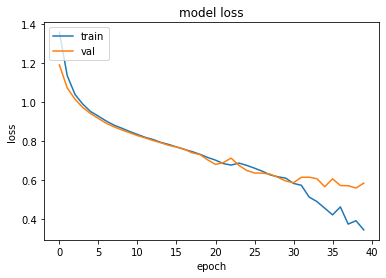

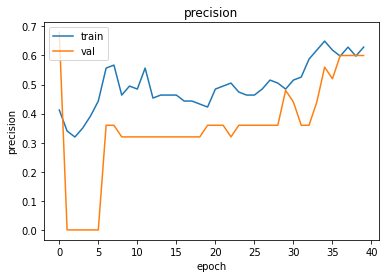

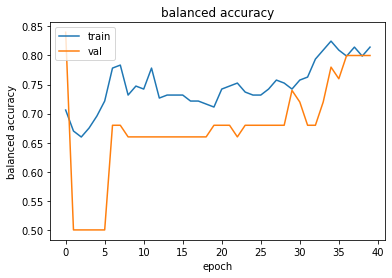

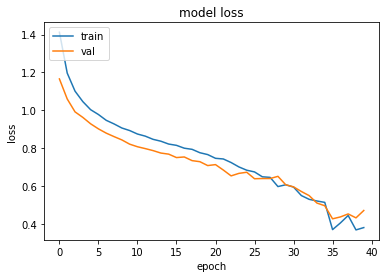

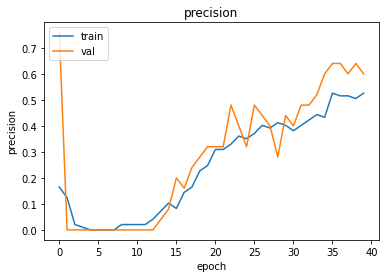

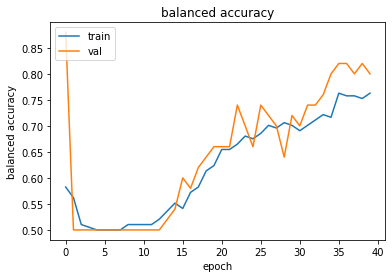

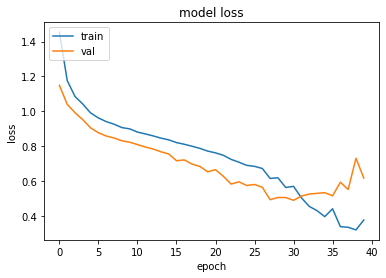

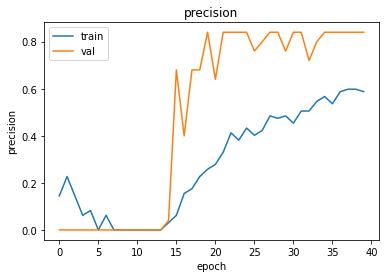

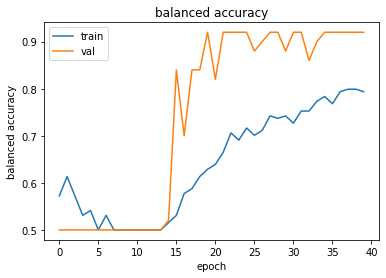

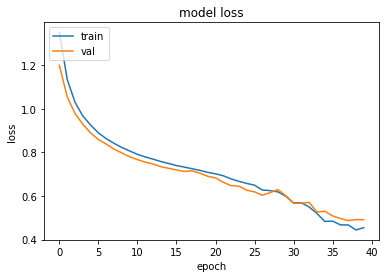

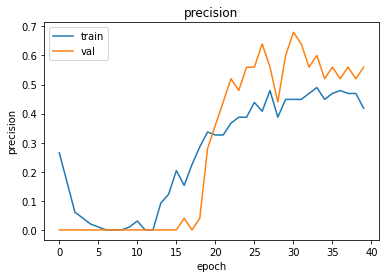

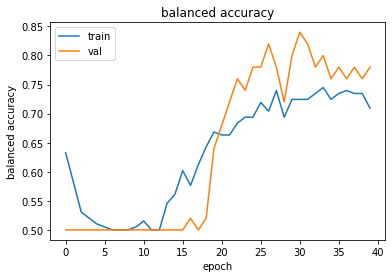

In [11]:
from functions import Get_train_valid_Path
from Data_aug import DataGenerator
import numpy as np
import cv2
import skimage.io
import skimage.transform
import imageio

input_dim = (64,64,3) #Verifier les inputs

run = 1
n_folds = 4
acc = np.zeros((run, n_folds), dtype=float)
data_path = '/content/drive/MyDrive/3md3070-dlmi/trainset'

for irun in range(run):
  dataset = load_dataset(path=data_path, n_folds=n_folds, rand_state=irun)

  for ifold in tqdm(range(n_folds)):
      print ('run=', irun, '  fold=', ifold)
      acc[irun][ifold] = model_training(input_dim, dataset[ifold], irun, ifold)
print ('mi-net mean accuracy = ', np.mean(acc))
print ('std = ', np.std(acc))

## Test

In [12]:
def test_batch():
        bags = []
        patient_ID=[]
        path='/content/drive/MyDrive/3md3070-dlmi/testset/'
      
        for i in df['ID'].unique():
            if df[df['ID']==i]['LABEL'].unique()[0]==-1:
              print(i)
              patient_ID.append(i)
              img = []
              img_path = glob.glob(path+ i +'/*.jpg')
              

              for j in range(len(img_path)):
                each_img=img_path[j]
                img_data=skimage.io.imread(each_img) 
                img_data=skimage.transform.resize(img_data, (64, 64))
                img.append(np.expand_dims(img_data,0))

              stack_img = np.concatenate(img, axis=0)
              bags.append((stack_img))

        return bags, patient_ID

bags_to_predict, patient_ID = test_batch()

P71
P16
P114
P170
P98
P69
P92
P132
P81
P73
P143
P175
P56
P139
P152
P203
P75
P9
P24
P4
P32
P120
P138
P172
P57
P195
P68
P133
P14
P119
P7
P49
P93
P178
P58
P108
P197
P196
P86
P18
P188
P148


In [13]:
from tensorflow.keras.models import load_model

model = load_model('/content/Saved_model/saved', custom_objects={'bag_loss': bag_loss,'BA': BA, 'precision_m':precision_m})
pred = []
label = []
for i in range(len(patient_ID)):
  aux = model.predict(bags_to_predict[i])
  #print(aux)
  pred.append(aux)
  label.append(round(aux[0][0]))

print(label)

results=pd.DataFrame({"ID":patient_ID, "Predicted":label})
results.to_csv(r'/content/soumission.csv', index=False)

[0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


## Logistic regression

In [14]:
from sklearn.linear_model import LogisticRegression

df0=pd.read_csv('/content/drive/MyDrive/3md3070-dlmi/clinical_annotation.csv')

dfm=df0[df0['LABEL']!=-1]
df1 = pd.get_dummies(dfm, prefix='', columns=['GENDER'])
df=df1[['ID','LABEL','DOB','LYMPH_COUNT','_M']]
df.columns=['ID','LABEL','DOB','LYMPH_COUNT','M']

from datetime import datetime

df['DOB'] =  pd.to_datetime(df['DOB'], infer_datetime_format=True)


annee=[]
patient_id=[]
a=0
for i in range(len(df)):
  try:
    annee+=[df['DOB'][i].year]
    patient_id+=[df['ID'][i]]
  except KeyError:
    a=0

dfage=pd.DataFrame(list(zip(annee,patient_id)), columns = ['YEAR','ID'])

df_modif=df.merge(dfage, on = ['ID'])


# Train of the logistic regression
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df_modif[['LYMPH_COUNT','YEAR']], df_modif['LABEL'], test_size=0.1, random_state=0)

logisticRegr = LogisticRegression(class_weight='balanced')
logisticRegr.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
df_predire=df0[df0['LABEL']==-1]

df_predire['DOB'] =  pd.to_datetime(df_predire['DOB'], infer_datetime_format=True)

annee=[]
patient_id=[]
a=0
for i in range(len(df0)):
  try:
    annee+=[df_predire['DOB'][i].year]
    patient_id+=[df_predire['ID'][i]]
  except KeyError:
    a=0


dfage=pd.DataFrame(list(zip(annee,patient_id)), columns = ['YEAR','ID'])

df_prediremodif=df_predire.merge(dfage, on = ['ID'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [16]:
def MIL_REG(model_mil, model_reg, bags, liste_patient_test, df_predire=df_prediremodif):
    """"
    model_mil : model with MIL
    bags : bags from test_batch()
    liste_patient_test : liste of patients names
    """
    label=[]
    number_pred_log=0
    number_pred_mil=0
    for i in range(len(liste_patient_test)):
      aux=model_mil.predict(bags[i])
      pred=np.round(aux[0][0],2)

      if pred<0.4 : 
        label+=[0]
        number_pred_mil+=1
      elif pred>0.6 : 
        label+=[1]
        number_pred_mil+=1
      else:
        x_test=df_predire[df_predire['ID']==liste_patient_test[i]]
        x_test=x_test[['LYMPH_COUNT','YEAR']]
        label+=[logisticRegr.predict(x_test)[0]]
        number_pred_log+=1
      
    
    return label, number_pred_log, number_pred_mil

In [17]:
label_2, number_pred_log, number_pred_mil = MIL_REG(model, logisticRegr, bags_to_predict, patient_ID, df_prediremodif)
print('There are', number_pred_log, 'bags which were predicted using the logistic regression.')

results_2=pd.DataFrame({"ID":patient_ID, "Predicted":label_2})
results_2.to_csv(r'/content/soumission_clinical_data.csv', index=False)

There are 3 bags which were predicted using the logistic regression.
